# Set Up

In [ ]:
!pip install torch-geometric

import torch

torch_version = torch.__version__.split("+")[0]
# !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch_version}+cpu.html
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00


## **MUTAG Dataset Overview**

The **MUTAG dataset** is a widely used **graph classification benchmark** in graph neural networks and cheminformatics.

## **What the Labels Describe**
- The **graph labels** in `DS_graph_labels.txt` indicate **whether a chemical compound is mutagenic (`1`) or non-mutagenic (`-1`)**.
- Each **graph represents a molecule**, where:
  - **Nodes** correspond to **atoms**.
  - **Edges** represent **chemical bonds** between atoms.

## **Breakdown of Labels**
### **Graph Labels (`DS_graph_labels.txt`)**
- **1** → Mutagenic (potentially causes genetic mutations).
- **-1** → Non-mutagenic (does not cause genetic mutations).

### **Node Labels (`DS_node_labels.txt`)**
The node labels represent different **atom types**:
- **0** → Carbon (C)
- **1** → Oxygen (O)
- **2** → Nitrogen (N)
- **3** → Fluorine (F)

## **Why is this dataset useful?**
- The dataset helps **train Graph Neural Networks (GNNs)** to predict whether a molecule has mutagenic properties based on its atomic structure.
- It’s commonly used in **drug discovery and toxicity prediction** in computational chemistry.


# DataLoader

In [ ]:
from torch_geometric.datasets import TUDataset
import numpy as np
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv, global_mean_pool

# Download and load the MUTAG dataset
dataset = TUDataset(root="data/MUTAG", name="MUTAG")

# Display dataset information
print(f"Number of graphs: {len(dataset)}")
print(f"First graph: {dataset[0]}")
print(f"Number of nodes in the first graph: {dataset[0].num_nodes}")
print(f"Number of edges in the first graph: {dataset[0].num_edges}")

Processing...


Number of graphs: 188
First graph: Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes in the first graph: 17
Number of edges in the first graph: 38


Done!


# Data Visualizer


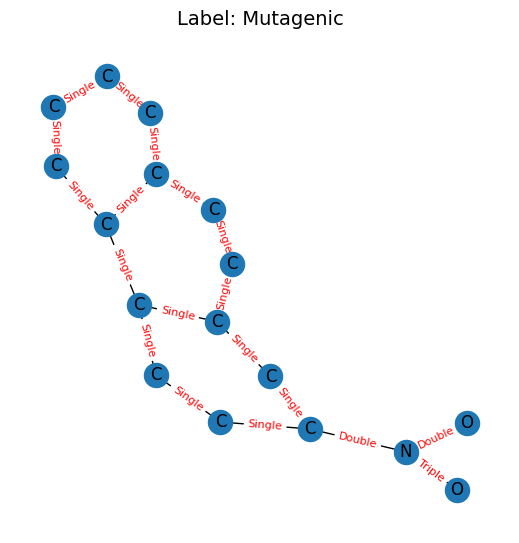

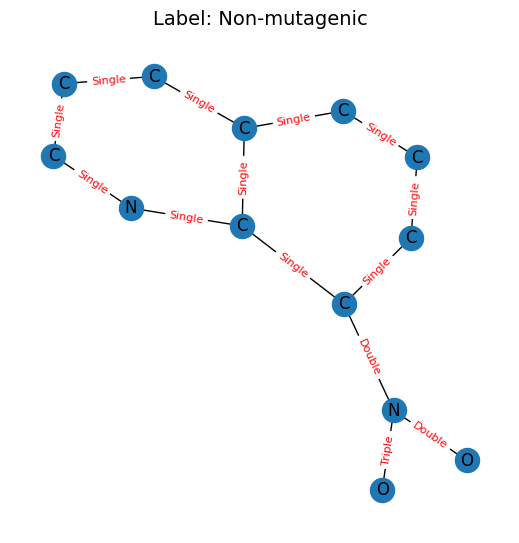

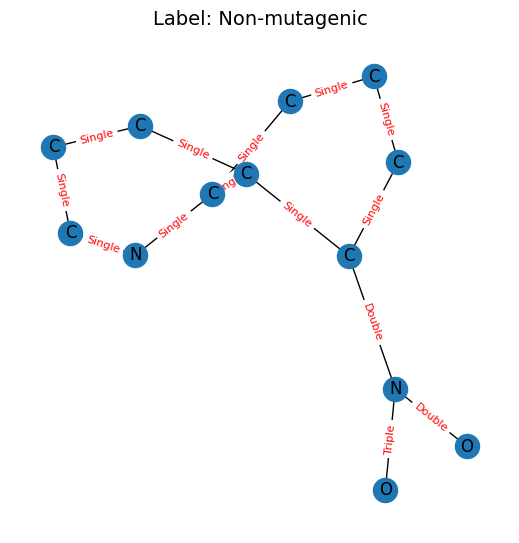

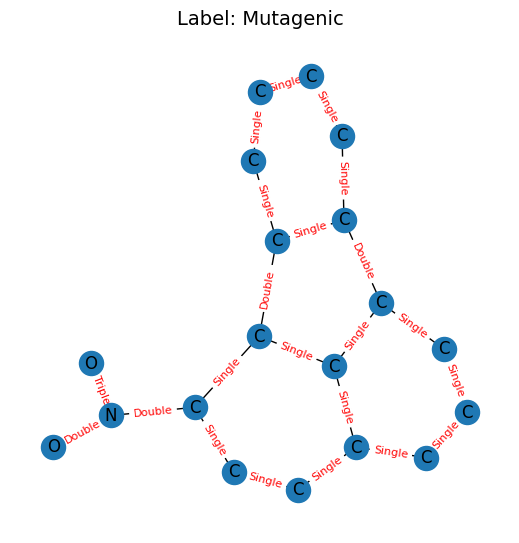

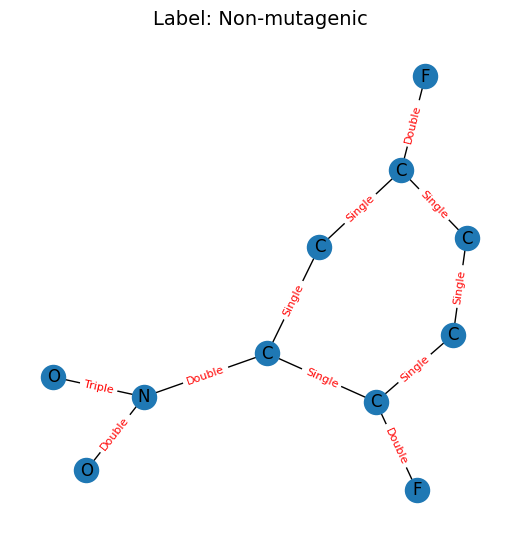

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

atom_labels = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
bond_labels = ['Single', 'Double', 'Triple', 'Aromatic']

for g in range(5):

  G = to_networkx(dataset[g], to_undirected=True)

  node_labels = {}
  for i in range(dataset[g].num_nodes):
      if dataset[g].x[i].sum() == 0:
          node_labels[i] = "?"
      else:
          node_labels[i] = atom_labels[int(dataset[g].x[i].argmax())]

  # Create edge labels
  edge_labels = {}
  edge_list = dataset[g].edge_index.t().tolist()
  for idx, (u, v) in enumerate(edge_list):
      bond_type = dataset[g].edge_attr[idx].argmax().item()
      bond_label = bond_labels[bond_type]
      edge_labels[(u, v)] = bond_label

  plt.figure(figsize=(5,5))
  nx.draw(
      G,
      pos=nx.spring_layout(G, seed=42),
      with_labels=True,
      labels=node_labels
  )

  nx.draw_networkx_edge_labels(G, pos = nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_size=8, font_color='red')
  label_text = f"Label: {'Mutagenic' if dataset[g].y.item() == 1 else 'Non-mutagenic'}"
  plt.title(label_text, fontsize=14)
  plt.axis('off')
  plt.show()


# Models

### Graph Data Flow

We are working with the MUTAG dataset, where each **graph represents a molecule**, with:

- **17 nodes** (atoms), each with **7 one-hot encoded features** (atom types: C, N, O, F, I, Cl, Br).
- **38 edges** (chemical bonds), each with **4 one-hot encoded features** (bond types: Single, Double, Triple, Aromatic).
- **1 label `y`** per graph indicating whether the compound is **mutagenic (1)** or **non-mutagenic (0)**.

---

### Model Architecture

Our model consists of:

1. `GCNConv(num_node_features, hidden_dim)` — learns to transform node features while aggregating from neighbors.
2. `GCNConv(hidden_dim, hidden_dim)` — further transforms and refines node embeddings.
3. `global_mean_pool()` — compresses node embeddings into a graph-level vector.
4. `Linear(hidden_dim, num_classes)` — maps the graph vector to final class scores.

---

### Step-by-Step Data Flow

#### Step 1: Input Graph
We start with a `Data` object (from PyG), which contains:
- `x`: a `[17, 7]` matrix of node features (atoms)
- `edge_index`: a `[2, 38]` matrix indicating which nodes are connected
- `edge_attr`: a `[38, 4]` matrix of bond types (currently unused)
- `y`: a `[1]` graph-level label
- `batch`: maps each node to its graph (important during batching)

---

#### Step 2: First GCN Layer

`x = self.conv1(x, edge_index)`
- Each node’s 7D feature vector is transformed and updated based on its own features and those of its neighbors.
- The graph structure in edge_index controls which nodes communicate.
- This gives a new x with shape [17, hidden_dim].

---

#### Step 3: ReLu

`x = F.relu(x)`

- Applies non-linearity to help the model learn complex patterns.

---

#### Step 4: Second GCN Layer and ReLu

`x = self.conv2(x, edge_index)`

`x = F.relu(x)`

- A second round of graph convolution, allowing information to propagate deeper (e.g., 2-hop neighbors).
- Again uses the graph structure from edge_index.

---

#### Step 5, 6: Global Mean Pooling and Fully Connected Layer

`x = global_mean_pool(x, batch)`

`x = self.fc(x)`


- Aggregates all node embeddings into one graph embedding by averaging.
- The batch tensor ensures that this works properly when multiple graphs are processed in parallel.
- Maps the graph embedding to final class scores (e.g., logits for classifying mutagenic vs non-mutagenic).


In [ ]:
class RGCN(torch.nn.Module):
    def __init__ (self, num_node_features, hidden_dim, num_classes, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(num_node_features, hidden_dim, num_relations)
        self.conv2 = RGCNConv(hidden_dim, hidden_dim, num_relations)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        edge_type = edge_attr.argmax(dim=1)

        # The RGCN Logic (Info from neighboring nodes) is embedded by the RGCNConv Function (see__init__) in the self.conv layers

        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [ ]:
#class models():
  # Defines the full R-GCN model (encoder + decoder)

In [ ]:
#def utils():
  # Helper functions for model operations

# Training

In [ ]:
train_dataset = dataset[:150]  # First 150 for training
test_dataset = dataset[150:]   # Rest for testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Main training script for R-GCN

train_accuracies = []
test_accuracies = []

def train():

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(47)
  model = RGCN(num_node_features=dataset.num_node_features, hidden_dim=16, num_classes=2, num_relations=4).to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(200):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate at each 10 epochs
    if (epoch+1) % 10 == 0:
      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

      # Training Eval
      model.eval()
      correct = 0
      total = 0

      for data in train_loader:
          data = data.to(device)
          out = model(data)
          pred = out.argmax(dim=1)
          correct += (pred == data.y).sum().item()
          total += data.num_graphs  # total number of graphs in the batch

      train_acc = correct / total
      train_accuracies.append(train_acc)

      # Test Eval
      model.eval()
      correct = 0
      total = 0

      with torch.no_grad():
        for data in test_loader:
          data = data.to(device)
          out = model(data)
          pred = out.argmax(dim=1)  # Get the predicted class
          correct += (pred == data.y).sum().item()  # Count correct predictions
          total += data.y.size(0)

      test_acc = correct / total
      test_accuracies.append(test_acc)

  print(f"Training Accuracies: {train_accuracies}")
  print(f"Test Accuracies: {test_accuracies}")
  return model

if __name__ == "__main__":
  trained_model = train()

Epoch 10, Loss: 2.6747
Epoch 20, Loss: 2.4511
Epoch 30, Loss: 2.4336
Epoch 40, Loss: 2.2996
Epoch 50, Loss: 2.2259
Epoch 60, Loss: 2.1380
Epoch 70, Loss: 2.0485
Epoch 80, Loss: 1.9450
Epoch 90, Loss: 1.9542
Epoch 100, Loss: 1.7844
Epoch 110, Loss: 1.6948
Epoch 120, Loss: 1.5649
Epoch 130, Loss: 1.7555
Epoch 140, Loss: 1.5496
Epoch 150, Loss: 1.4109
Epoch 160, Loss: 1.4673
Epoch 170, Loss: 1.4038
Epoch 180, Loss: 1.5280
Epoch 190, Loss: 1.3343
Epoch 200, Loss: 1.3053
Training Accuracies: [0.74, 0.76, 0.7933333333333333, 0.78, 0.8, 0.8, 0.8133333333333334, 0.8266666666666667, 0.8333333333333334, 0.8333333333333334, 0.8533333333333334, 0.8533333333333334, 0.8533333333333334, 0.8866666666666667, 0.88, 0.9, 0.9, 0.9066666666666666, 0.8933333333333333, 0.8933333333333333]
Test Accuracies: [0.7105263157894737, 0.7368421052631579, 0.7631578947368421, 0.8157894736842105, 0.8157894736842105, 0.8157894736842105, 0.7631578947368421, 0.7631578947368421, 0.7631578947368421, 0.7631578947368421, 0.789

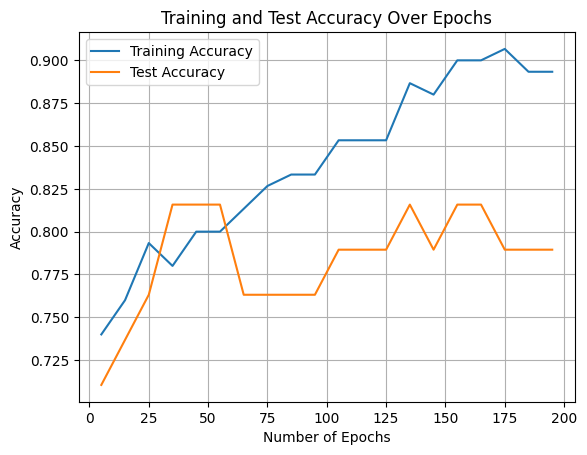

In [ ]:
plt.plot(ver, train_accuracies, label='Training Accuracy')
plt.plot(ver, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Test Accuracy Over Epochs')
plt.show()

# K-Fold CV

In [ ]:
from sklearn.model_selection import KFold
import copy

def kfold_cv_train(k = 5, num_epochs = 100):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.manual_seed(47)
  kf = KFold(n_splits=k, shuffle=True, random_state=42)

  best_model_state = None
  best_test_acc = 0.0
  best_fold = -1

  cv_train_accuracies = np.zeros((k, num_epochs))
  cv_test_accuracies = np.zeros((k, num_epochs))

  for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{k}")
    train_dataset = [dataset[i] for i in train_index]
    test_dataset = [dataset[i] for i in test_index]

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = RGCN(num_node_features=dataset.num_node_features, hidden_dim=16, num_classes=2, num_relations=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
      model.train()
      total_loss = 0

      for data in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          out = model(data)
          loss = criterion(out, data.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      model.eval()
      correct = 0
      total = 0
      for data in train_loader:
          data = data.to(device)
          out = model(data)
          pred = out.argmax(dim=1)
          correct += (pred == data.y).sum().item()
          total += data.num_graphs
          correct += (pred == data.y).sum().item()
          total += data.num_graphs  # total number of graphs in the batch

      train_acc = correct / total
      cv_train_accuracies[fold, epoch] = train_acc

      # Test Eval
      model.eval()
      correct = 0
      total = 0

      with torch.no_grad():
        for data in test_loader:
          data = data.to(device)
          out = model(data)
          pred = out.argmax(dim=1)  # Get the predicted class
          correct += (pred == data.y).sum().item()  # Count correct predictions
          total += data.y.size(0)

      test_acc = correct / total
      cv_test_accuracies[fold, epoch] = test_acc

      # Save best model
      if cv_test_accuracies[fold, -1] > best_test_acc:
          best_test_acc = cv_test_accuracies[fold, -1]
          best_model_state = copy.deepcopy(model.state_dict())
          best_fold = fold


    # Retrieve best Model

  best_model = RGCN(
        num_node_features=dataset.num_node_features,
        hidden_dim=16,
        num_classes=dataset.num_classes,
        num_relations=4
    ).to(device)
  best_model.load_state_dict(best_model_state)

  return best_model, cv_train_accuracies, cv_test_accuracies

if __name__ == "__main__":
  trained_model, cv_train_accuracies, cv_test_accuracies = kfold_cv_train()

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


## Display

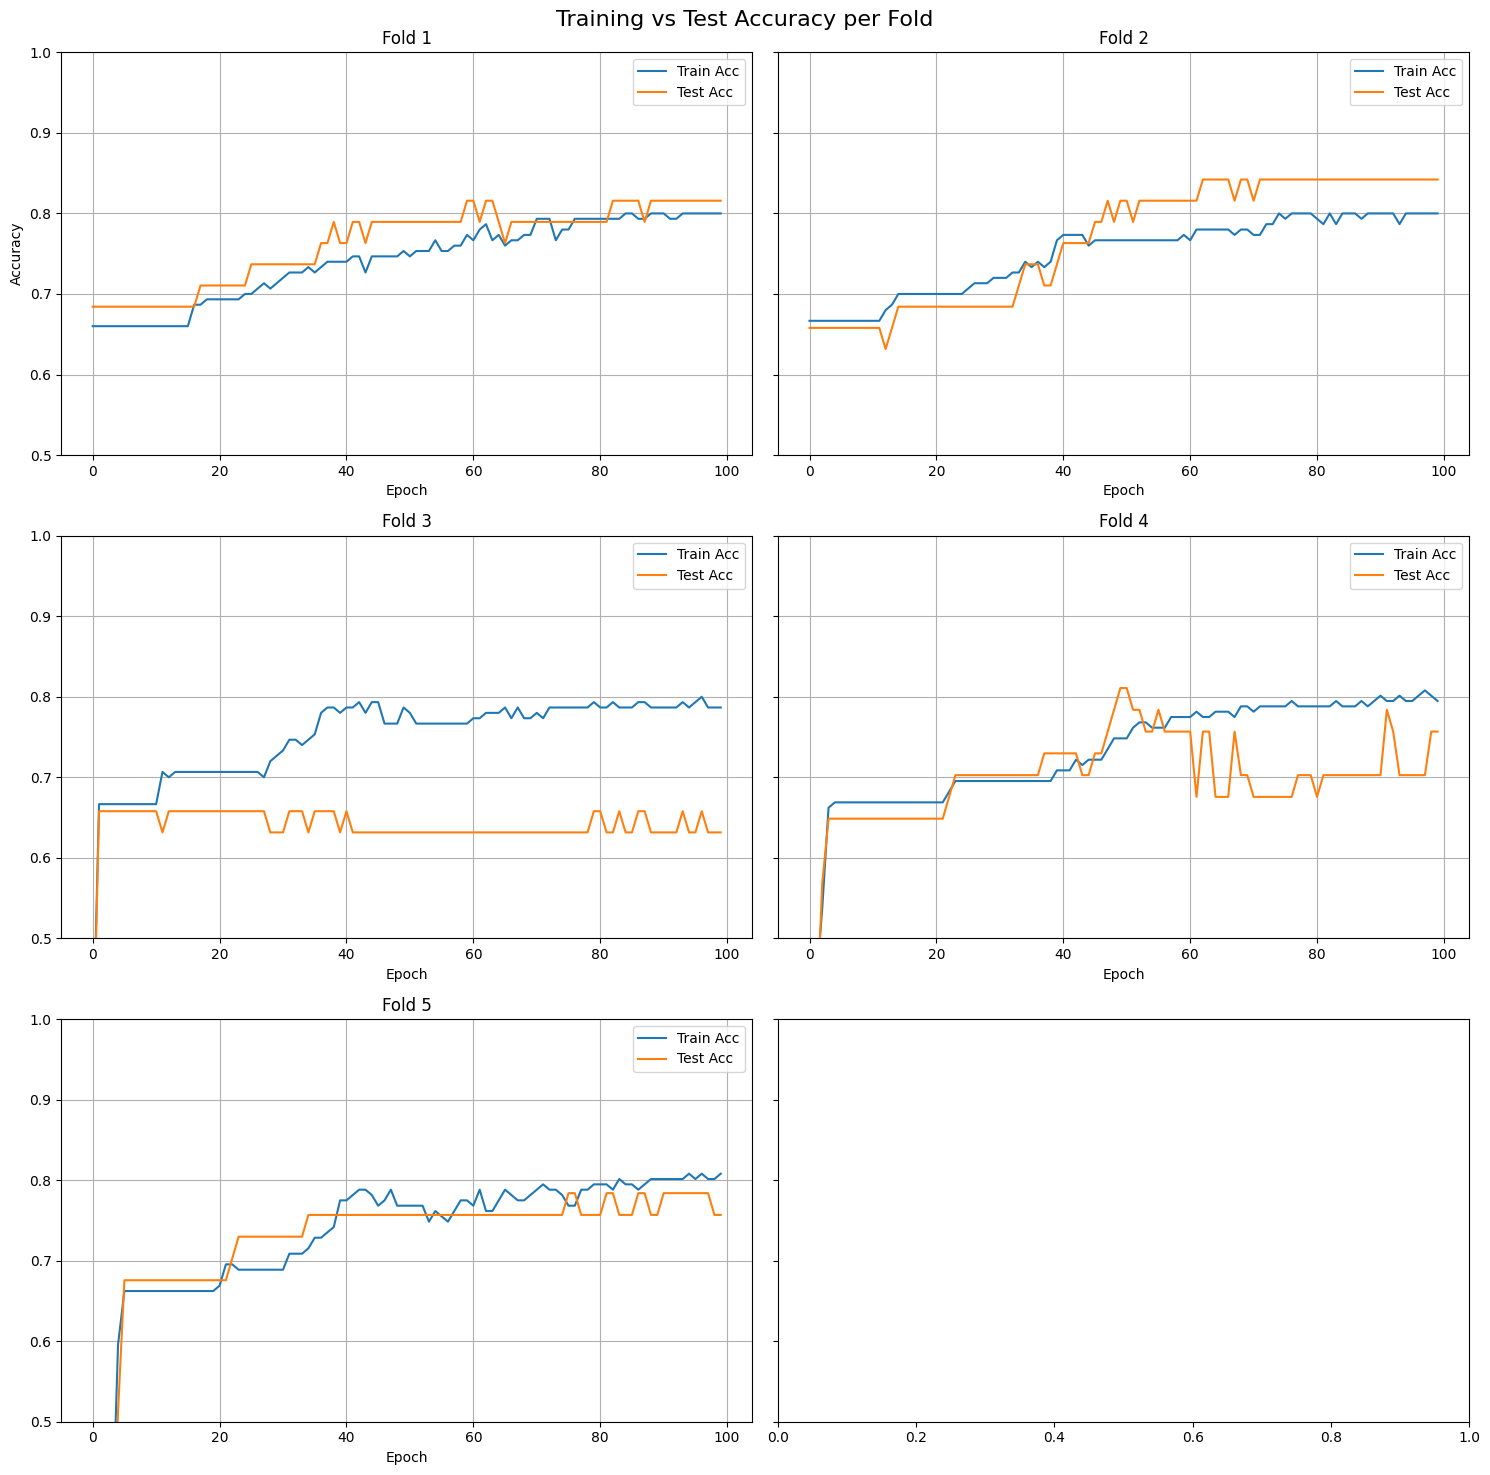

In [ ]:
ver = np.arange(1, 101)

fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axs = axs.flatten()

for fold in range(5):
    axs[fold].plot(range(100), cv_train_accuracies[fold], label='Train Acc')
    axs[fold].plot(range(100), cv_test_accuracies[fold], label='Test Acc')
    axs[fold].set_title(f"Fold {fold + 1}")
    axs[fold].set_xlabel("Epoch")
    axs[fold].set_ylim(0.5, 1)
    axs[fold].grid(True)
    if fold == 0:
        axs[fold].set_ylabel("Accuracy")
    axs[fold].legend()

plt.suptitle("Training vs Test Accuracy per Fold", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#def loss():
  # Loss functions for link prediction and classification

In [ ]:
# Functions for evaluating model performance
def evaluation(model, test_loader, device):

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      data = data.to(device)
      out = model(data)
      pred = out.argmax(dim=1)  # Get the predicted class
      correct += (pred == data.y).sum().item()  # Count correct predictions
      total += data.y.size(0)

  accuracy = correct / total
  print(f"Test Accuracy: {accuracy:.4f}")
  return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluation(trained_model, test_loader, device)


Test Accuracy: 0.6579


0.6578947368421053

# Experiments

In [ ]:
def config():
  # Hyperparameters and settings for training/testing

In [ ]:
def run_experiments():
  # Script to run different training setups

# Utils

In [ ]:
def graph_utils():
  # Graph-related utilities (e.g., adjacency matrix handling)

In [ ]:
def sampling():
  # Negative sampling and graph subsetting methods

In [ ]:
def visualization():
  # Functions to visualize graphs and embeddings

# Pipeline